In [1]:
import os
import torch
import clip
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

Using device: cpu


In [3]:
def extract_features(image_paths, batch_size=32):
    """Extract features from images using CLIP model"""
    features = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting features"):
        batch_paths = image_paths[i:i+batch_size]
        images = []
        
        for path in batch_paths:
            try:
                image = preprocess(Image.open(path)).unsqueeze(0)
                images.append(image)
            except Exception as e:
                print(f"Error processing {path}: {e}")
                # Add a placeholder for failed images
                images.append(torch.zeros(1, 3, 224, 224))
        
        # Stack images into a batch
        image_batch = torch.cat(images).to(device)
        
        # Extract features
        with torch.no_grad():
            batch_features = model.encode_image(image_batch)
            
        # Normalize features
        batch_features = batch_features / batch_features.norm(dim=1, keepdim=True)
        features.append(batch_features.cpu())
    
    # Concatenate all features
    return torch.cat(features).numpy()

def find_similar_images(features, image_names, top_k=6):
    """Find top_k similar images for each image"""
    # Calculate similarity matrix
    similarity = np.dot(features, features.T)
    
    # Create a dataframe to store results
    results = []
    
    # For each image, find top_k similar images
    for i in range(len(image_names)):
        # Get similarity scores for current image
        scores = similarity[i]
        
        # Set self-similarity to -1 to exclude it
        scores[i] = -1
        
        # Get indices of top_k similar images
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        # Get names of top_k similar images
        top_names = [image_names[idx] for idx in top_indices]
        
        # Add to results
        results.append({
            'filename': image_names[i],
            'ranking': ' '.join(top_names)
        })
    
    return pd.DataFrame(results)

In [4]:
# Get all image paths
image_paths = list(Path('dataset').glob('*.png'))
image_paths = [str(path) for path in image_paths]

# Get image names (filenames without path)
image_names = [os.path.basename(path) for path in image_paths]

print(f"Found {len(image_paths)} images")

Found 9605 images


In [5]:
# Extract features
features = extract_features(image_paths)

Extracting features: 100%|██████████| 301/301 [21:21<00:00,  4.26s/it]    


In [6]:
# Find similar images
results_df = find_similar_images(features, image_names)

In [7]:
results_df.to_csv('submission.csv', index=False)
print(f"Results saved to submission.csv")

Results saved to submission.csv


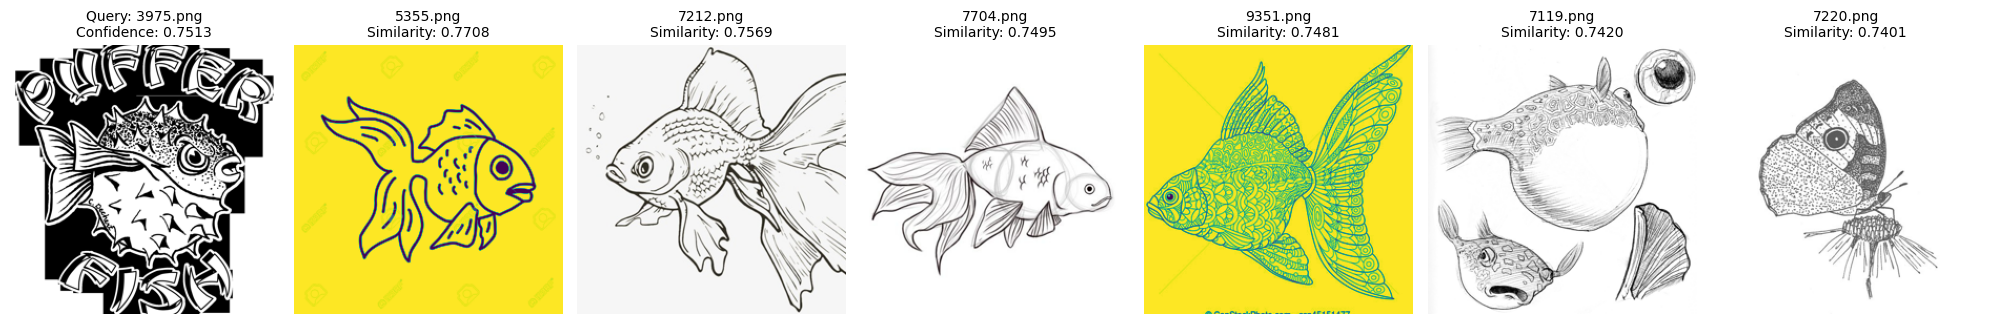

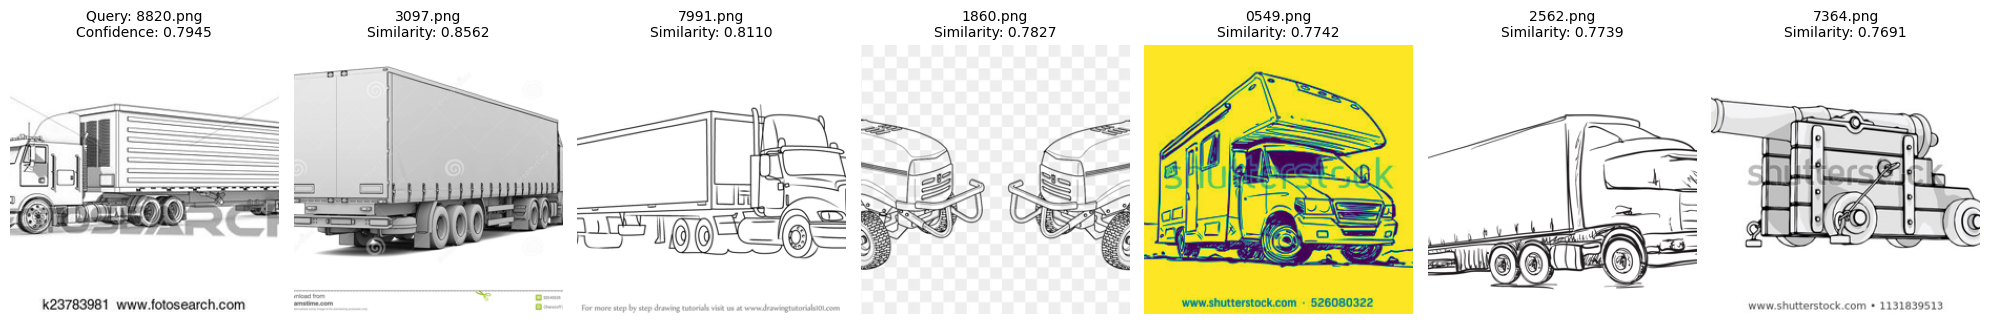

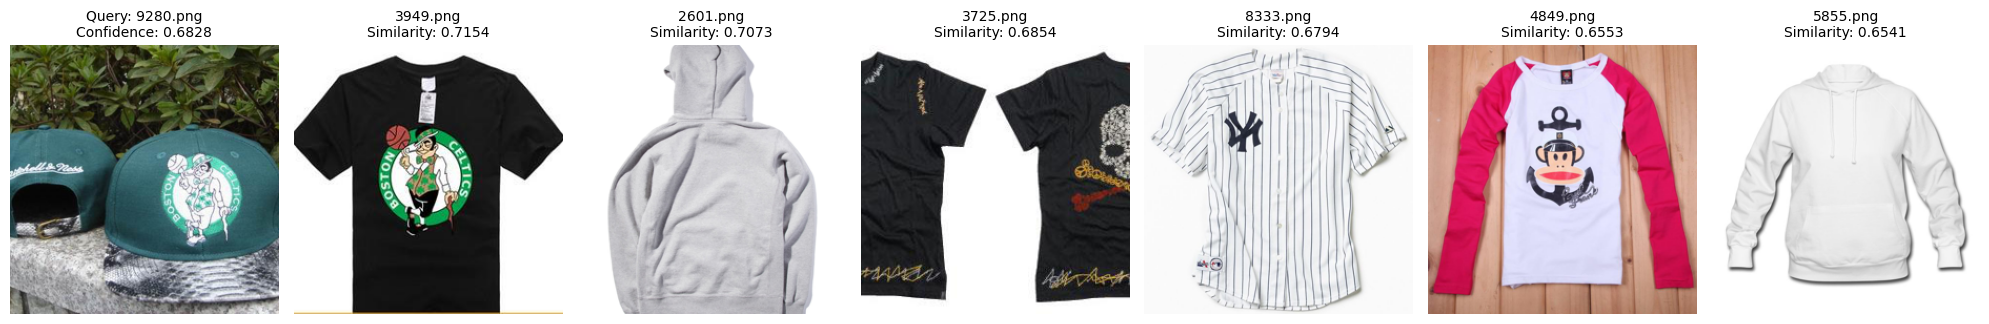

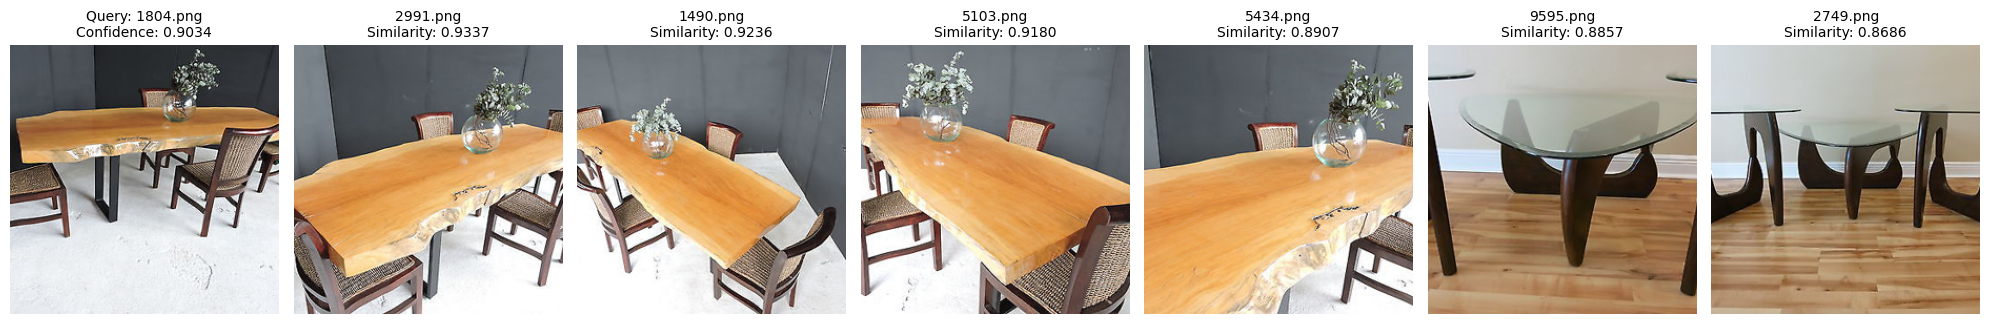

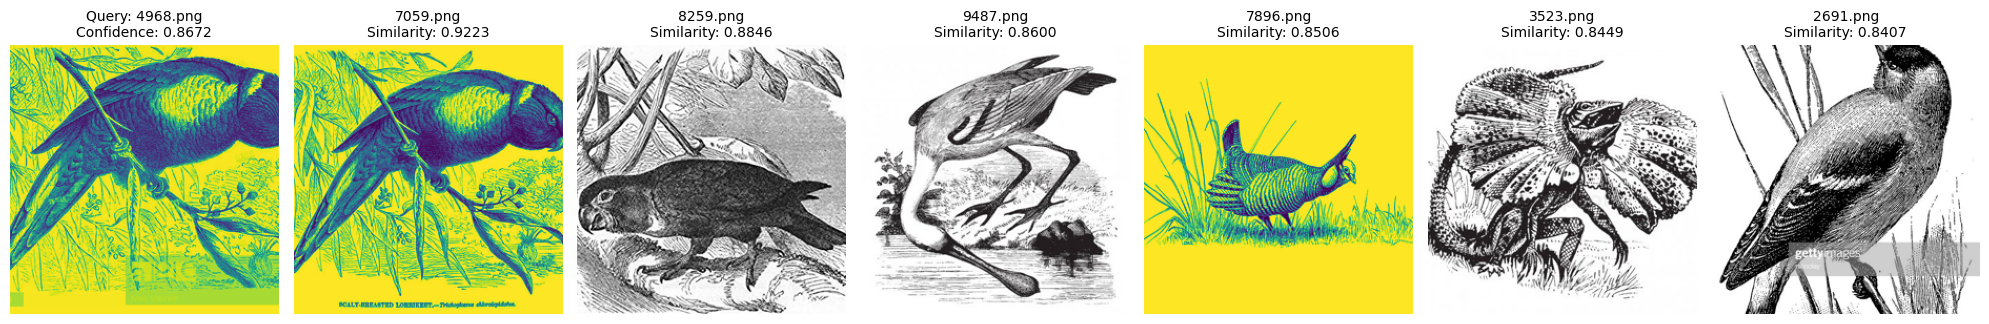

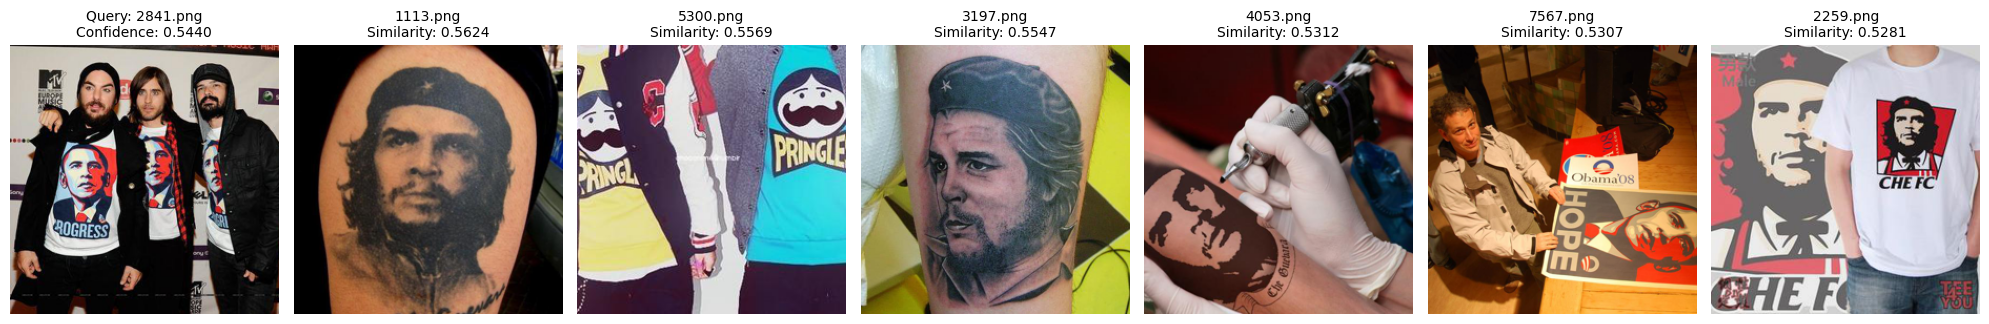

⬆️ This is the query with the lowest average confidence score: 0.5440


In [8]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def visualize_results(results_df, image_dir, num_samples=5, show_weakest=True):
    """
    Visualize query images and their top matches
    
    Args:
        results_df: DataFrame with results
        image_dir: Directory containing images
        num_samples: Number of samples to visualize
        show_weakest: Whether to show the weakest match
    """
    # Calculate confidence scores for each query
    confidence_scores = []
    
    for _, row in results_df.iterrows():
        query_name = row['filename']
        query_idx = image_names.index(query_name)
        
        # Get indices of recommended images
        recommended_names = row['ranking'].split()
        recommended_indices = [image_names.index(name) for name in recommended_names]
        
        # Calculate average similarity score for this query
        avg_similarity = np.mean([np.dot(features[query_idx], features[idx]) for idx in recommended_indices])
        confidence_scores.append(avg_similarity)
    
    # Add confidence scores to the dataframe
    results_df['confidence'] = confidence_scores
    
    # Get indices to visualize
    indices_to_show = list(range(min(num_samples, len(results_df))))
    
    if show_weakest:
        # Find the query with the lowest confidence
        weakest_idx = results_df['confidence'].argmin()
        if weakest_idx not in indices_to_show:
            indices_to_show.append(weakest_idx)
    
    # Visualize each selected query
    for idx in indices_to_show:
        row = results_df.iloc[idx]
        query_name = row['filename']
        recommended_names = row['ranking'].split()
        confidence = row['confidence']
        
        # Create a figure with 1 row and 7 columns (query + 6 recommendations)
        fig = plt.figure(figsize=(20, 4))
        gs = gridspec.GridSpec(1, 7, width_ratios=[1, 1, 1, 1, 1, 1, 1])
        
        # Display query image
        ax = plt.subplot(gs[0])
        query_img = Image.open(os.path.join(image_dir, query_name))
        ax.imshow(query_img)
        ax.set_title(f"Query: {query_name}\nConfidence: {confidence:.4f}", fontsize=10)
        ax.axis('off')
        
        # Display recommended images
        for i, rec_name in enumerate(recommended_names):
            ax = plt.subplot(gs[i+1])
            rec_img = Image.open(os.path.join(image_dir, rec_name))
            ax.imshow(rec_img)
            
            # Calculate similarity score between query and this recommendation
            query_idx = image_names.index(query_name)
            rec_idx = image_names.index(rec_name)
            similarity = np.dot(features[query_idx], features[rec_idx])
            
            ax.set_title(f"{rec_name}\nSimilarity: {similarity:.4f}", fontsize=10)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Add a note if this is the weakest match
        if idx == weakest_idx and show_weakest:
            print(f"⬆️ This is the query with the lowest average confidence score: {confidence:.4f}")

# Visualize the results
image_dir = 'dataset'  # Update this to your image directory
visualize_results(results_df, image_dir)